In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [2]:
#读取文件
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
#获取user和item数量
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users, n_items

(943, 1682)

In [4]:
#生成评分表
ratings = np.zeros((n_users,n_items))
for row in df.itertuples():  #返回一行元素，row[0]为行的idx
    ratings[row[1]-1,row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [5]:
#查看矩阵稀疏性
sparsity = float(len(ratings.nonzero()[0])) #返回n个array（每个array代表一维，array中数据表示每个非零元素在此维中的位置）
sparsity /= float(ratings.shape[0]*ratings.shape[1])
sparsity *= 100
sparsity

6.304669364224531

In [6]:
#分割训练集与测试集 从每个用户的评分中移出10个给测试集
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], size=10, replace=False) #从不为0的idx中选出10个，且不重复
        
        #分别赋值
        train[user,test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    
    # 测试是否完全正交
    assert(np.all((train * test) == 0))
    
    return train, test

In [7]:
train, test = train_test_split(ratings)

In [8]:
#计算相似度矩阵（余弦相似度）
def get_similarity(ratings, kind='user', epsilon=1e-9): #epsilon防止/0的错误发生
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [9]:
user_similarity = get_similarity(train, kind='user')
item_similarity = get_similarity(train, kind='item')
item_similarity[:4, :4]

array([[ 1.        ,  0.40654222,  0.33056097,  0.4649186 ],
       [ 0.40654222,  1.        ,  0.25800679,  0.48619195],
       [ 0.33056097,  0.25800679,  1.        ,  0.32494695],
       [ 0.4649186 ,  0.48619195,  0.32494695,  1.        ]])

In [10]:
#预测评分
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    if kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [11]:
#计算MSE
def get_mse(pred, test):
    #忽略test中为0的项
    pred = pred[test.nonzero()].flatten()
    test = test[test.nonzero()].flatten()
    return mean_squared_error(pred, test)

In [12]:
user_prediction = predict(train, user_similarity, kind='user')
item_prediction = predict(train, item_similarity, kind='item')

In [13]:
user_prediction[test.nonzero()].flatten()[:10]

array([ 0.29778653,  0.43403077,  0.8106263 ,  1.33492701,  2.4205519 ,
        1.23736365,  0.56904821,  1.58255785,  0.63270929,  0.63834894])

In [14]:
test[test.nonzero()].flatten()[:10]

array([ 5.,  3.,  4.,  4.,  4.,  3.,  1.,  4.,  3.,  2.])

In [15]:
get_mse(user_prediction, test)

8.3223474334035394

In [16]:
get_mse(item_prediction, test)

11.433532793186847

In [17]:
#使用k个最相似的用户/物品来预测评分
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):  #每一个用户i
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]] #对与用户i相似的用户进行相似度排序并取最大的k个
            for j in range(ratings.shape[1]): #每一个物品j
                pred[i,j] = similarity[i,:][top_k_users].dot(ratings[:,j][top_k_users]) #i与topk用户的相似度矩阵与topk用户对物品j的评分矩阵相乘
                pred[i,j] /= np.sum(np.abs(similarity[i,:][top_k_users])) #i与topk相似度的绝对值和
    if kind == 'item':
        for i in range(ratings.shape[1]): #每一个物品i
            top_k_items = [np.argsort(similarity[:,i])[:-k-1:-1]] #对与物品i相似的物品进行相似度排序并取最大的k个
            for j in range(ratings.shape[0]): #每一个用户j
                pred[j,i] = similarity[i,:][top_k_items].dot(ratings[j,:][top_k_items].T) #i与topk物品的相似度与用户j对k个物品的评分矩阵的转置相乘
                pred[j,i] /= np.sum(np.abs(similarity[i,:][top_k_items])) #i与topk相似度的绝对值和
    return pred

In [20]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
pred[test.nonzero()].flatten()[:10]

array([ 0.21510355,  1.05655566,  1.76485048,  2.93650592,  4.00412926,
        2.49950543,  1.95349463,  3.08243216,  1.51577616,  0.79289006])

In [21]:
get_mse(pred, test)

6.4195485700768469

In [22]:
pred = predict_topk(train, item_similarity, kind='item', k=40)
pred[test.nonzero()].flatten()[:10]

array([ 1.99349971,  1.79040102,  2.32145486,  3.02774064,  3.79870084,
        2.63191191,  1.64349541,  3.51359479,  2.68081148,  1.67994811])

In [23]:
get_mse(pred, test)

7.6458960579818198

In [32]:
#尝试无偏移量（用均值衡量评分高低）的topk CF
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1) #按行计算每一个用户的评分均值 (shape（n,）)
        ratings = (ratings - user_bias[:, np.newaxis]).copy() #插入新维度后可将uesr_bias转换为shape（n，1） #拷贝ratings
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0) #按列计算每一个物品的平均得分 shape:(m,)
        ratings = (ratings - item_bias[np.newaxis,:]).copy()  #插入新维度后shape:(1,m)
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis,:]
    return pred

In [33]:
pred = predict_topk_nobias(train, user_similarity, kind='user', k=40)
pred[test.nonzero()].flatten()[:10]

array([ 0.55932128,  0.69556552,  1.07216106,  1.59646177,  2.68208666,
        1.49889841,  0.83058297,  1.84409261,  0.89424405,  0.89988369])

In [34]:
get_mse(pred, test)

8.6048976576291238

In [36]:
pred = predict_topk_nobias(train, item_similarity, kind='item', k=40)
pred[test.nonzero()].flatten()[:10]

array([ 0.96677123,  0.90040721,  1.16741129,  1.53148714,  2.3539352 ,
        1.46215659,  1.00205074,  1.71524917,  1.10903075,  1.15245249])

In [37]:
get_mse(pred, test)

9.6172643069445787

In [27]:
#用实验来确定最佳的k值
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_train_mse = []
item_test_mse = []

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]

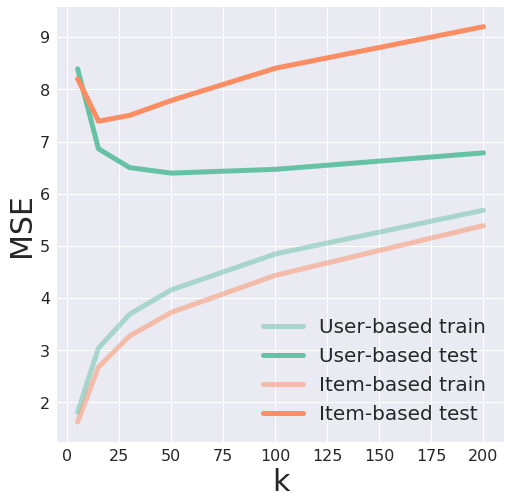

In [28]:
#画出mse的变化图像
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8,8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);